In [98]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Exploratory stuff from 2nd half of September

## Plot max expression angles for all genes

## Get angles for each time course point

## Scale each micro-array value with GTEX median tpm, for now, whole blood

## Decide on phase separation on the circle - visual for now

## Export micro-array data as single-cell dataset to classify with Seurat - see if have some coherence

In [2]:
# Read in the GTex Data pick tissue to use for normalization
#gtex paper: cite? https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4010069/
# https://gtexportal.org/home/datasets
# This file contains the median TPM by tissue. These medians were calculated directly from the file GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_tpm.gct.gz.
# wget https://storage.googleapis.com/gtex_analysis_v7/rna_seq_data/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_median_tpm.gct.gz
# for now, picking whole blood
import pandas as pd
tpm_df = pd.read_csv("GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_median_tpm.gct", sep='\t')
gene_name_to_tpm_dict = dict()
for index, row in tpm_df.iterrows():
    gene_name_to_tpm_dict[row["Description"]] = row["Whole Blood"]


In [25]:
# Read in the micro-array data - so far only founds matches between 1230 genes in whitfield in the 56K genes from GTEX
# TODO - get better name mapping
import math
import numpy as np
count = 0
count_found = 0
whitfield_micro_array_df = pd.read_csv("Whitfield_2013_cell_cycle_2830_all_scores.csv")

gene_names_with_micro_array_data = list()

time_course_1_angles_list = list()
time_course_2_angles_list = list()
time_course_3_angles_list = list()
time_course_4_angles_list = list()
names_for_all_time_courses_list = list()
gene_name_to_time_course_expressions_dict = dict()

# calculate the angles for the 4 time courses
for i in range(0,40,2): #t-course 1 T = 17.65, φ = 0.0
    #print(math.atan2(math.sin((i/17.65)*2*math.pi),math.cos((i/17.65)*2*math.pi))) # with negative radians
    time_course_1_angles_list.append(((i/17.65)*2*math.pi)%(2*math.pi)) # 0 to 2pi
    names_for_all_time_courses_list.append("t1_" + str(i))
for i in range(0,48,2): #t-course 2 T = 18.6, φ = 0.0
    #print(math.atan2(math.sin((i/18.6)*2*math.pi),math.cos((i/18.6)*2*math.pi))) # with negative radians
    time_course_2_angles_list.append(((i/18.6)*2*math.pi)%(2*math.pi)) # 0 to 2pi
    names_for_all_time_courses_list.append("t2_" + str(i))
for i in range(0,48,2): #t-course 3 T = 18, φ = 0.0
    #print(math.atan2(math.sin((i/18)*2*math.pi),math.cos((i/18)*2*math.pi))) # with negative radians
    time_course_3_angles_list.append(((i/18)*2*math.pi)%(2*math.pi)) # 0 to 2pi
    names_for_all_time_courses_list.append("t3_" + str(i))
for i in range(0,46,2): #t-course 4 T = 23.95, φ = 2.3
    #print(math.atan2(math.sin((i/23.95)*2*math.pi + 2.3),math.cos((i/23.95)*2*math.pi + 2.3))) # with negative radians
    time_course_4_angles_list.append(((i/23.95)*2*math.pi + 2.3)%(2*math.pi)) # 0 to 2pi
    names_for_all_time_courses_list.append("t4_" + str(i))
    
for index, row in whitfield_micro_array_df.iterrows():
    count +=1
    name = str(row['NAME'])
    if (name != 'nan'):
        #print("___" + name + "___")
        names = name.split("^")
        if (len(names) > 1):
            #print("___" + names[1] + "___")
            gene_name = names[1].strip()
            if (gene_name in gene_name_to_tpm_dict and not(gene_name in gene_names_with_micro_array_data)):
                
                
                ####!!!! cut-off to have just a few top cycling genes
                scaled_fourier_score = float(row['Scaled Fourier'])
                #if (scaled_fourier_score < 10.0):
                 #   continue
                tpm = gene_name_to_tpm_dict[gene_name]
                #print(gene_name + " is found")
                gene_names_with_micro_array_data.append(gene_name)
                count_found += 1
                gene_name_to_time_course_expressions_dict[gene_name] = dict()
                gene_name_to_time_course_expressions_dict[gene_name]["one"] = list()
                
                
                new_row = row[11:31].replace(r'\s+', np.nan, regex=True)
                new_row = new_row.fillna(0)
                row[11:31] = new_row
            
                new_row = row[32:56].replace(r'\s+', np.nan, regex=True)
                new_row = new_row.fillna(0)
                row[32:56] = new_row
                
                new_row = row[57:81].replace(r'\s+', np.nan, regex=True)
                new_row = new_row.fillna(0)
                row[57:81] = new_row
                
                new_row = row[82:105].replace(r'\s+', np.nan, regex=True)
                new_row = new_row.fillna(0)
                row[82:105] = new_row
                
                
                #TODO: for now adding zero to missing time courses and samples - valid for all things?
                
                for i in range(11,31):
                    gene_name_to_time_course_expressions_dict[gene_name]["one"].append((2**row[i]) * tpm if row[i] else 0) # undo the log2 of data
                gene_name_to_time_course_expressions_dict[gene_name]["two"] = list()
                for i in range(32,56):
                    gene_name_to_time_course_expressions_dict[gene_name]["two"].append((2**row[i]) * tpm if row[i] else 0) # undo the log2 of data
                gene_name_to_time_course_expressions_dict[gene_name]["three"] = list()
                for i in range(57,81):
                    gene_name_to_time_course_expressions_dict[gene_name]["three"].append((2**row[i]) * tpm if row[i] else 0) # undo the log2 of data
                gene_name_to_time_course_expressions_dict[gene_name]["four"] = list()
                for i in range(82,105):
                    gene_name_to_time_course_expressions_dict[gene_name]["four"].append((2**row[i]) * tpm if row[i] else 0) # undo the log2 of data
    
                gene_name_to_time_course_expressions_dict[gene_name]["sine"] = row['Sin']
                gene_name_to_time_course_expressions_dict[gene_name]["cosine"] = row['Cos']
                gene_name_to_time_course_expressions_dict[gene_name]["phase"] = row['Phase'].strip()
print(count_found)
#print(gene_name_to_time_course_expressions_dict['KLF6'])

#print(gene_name_to_time_course_expressions_dict["PITPNC1"])

1230


In [31]:
## make micro-array dataframe for seurat's input
import csv
count = 0
whitfield_subset_micro_array_df = pd.DataFrame(columns = names_for_all_time_courses_list)
for gene_name in gene_names_with_micro_array_data:
    count += 1
    whitfield_subset_micro_array_df.loc[gene_name] = gene_name_to_time_course_expressions_dict[gene_name]["one"] + gene_name_to_time_course_expressions_dict[gene_name]["two"] + gene_name_to_time_course_expressions_dict[gene_name]["three"] + gene_name_to_time_course_expressions_dict[gene_name]["four"]
print(count)
whitfield_subset_micro_array_df.to_csv("whitfield_micro_array_as_sc.csv", sep='\t', index=True)

1230


In [53]:
## read in the Seurat phase assignments 

angles_list = time_course_1_angles_list + time_course_2_angles_list + time_course_3_angles_list + time_course_4_angles_list

whitfield_seurat_df = pd.read_csv("whitfield_micro_seurat_labels.csv", sep=',')
whitfield_seurat_phase_list = list()
for index, row in whitfield_seurat_df.iterrows():
    whitfield_seurat_phase_list.append(row["Phase"])
    
whitfield_seurat_df = pd.read_csv("whitfield_micro_seurat_labels_short_list.csv", sep=',')
whitfield_seurat_short_list_phase_list = list()
for index, row in whitfield_seurat_df.iterrows():
    whitfield_seurat_short_list_phase_list.append(row["Phase"])
    

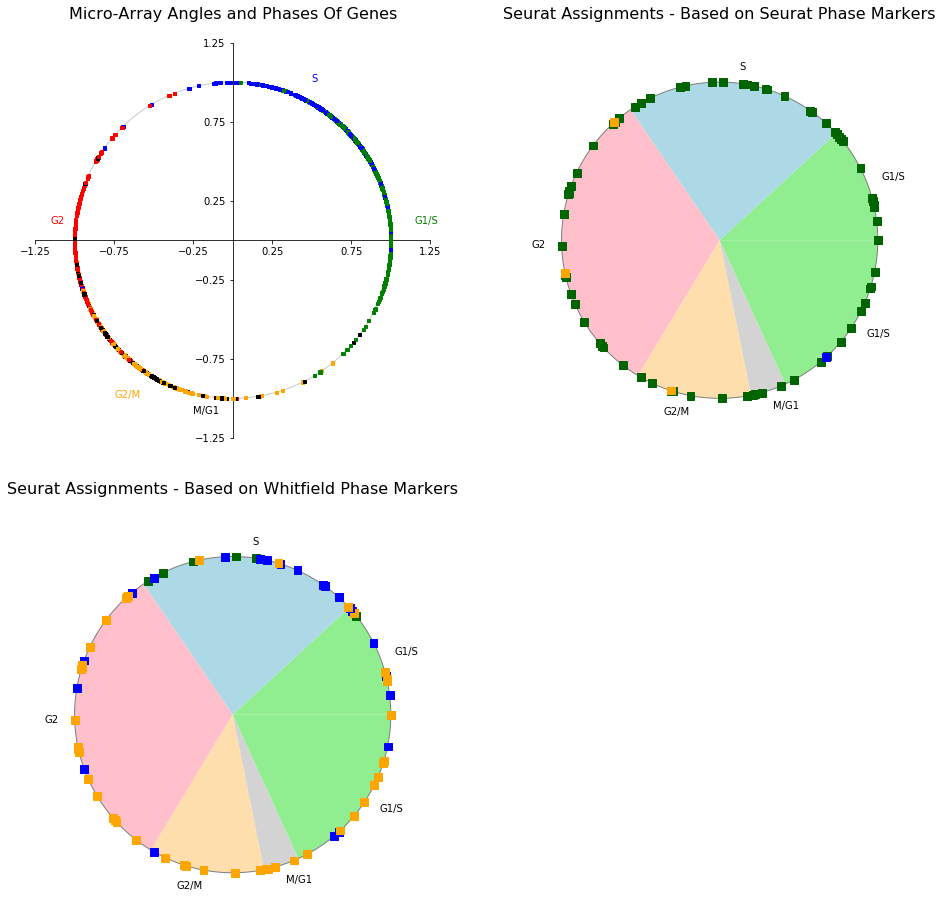

In [55]:
#print(whitfield_subset_micro_array_df)
#print(whitfield_subset_micro_array_df.sum(axis=0))
from pylab import *
figure(figsize=(16,16))


#### All Genes
ax=subplot(221, aspect='equal')

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.xaxis.set_ticks(np.arange(-1.25, 1.5, 0.5))
ax.yaxis.set_ticks(np.arange(-1.25, 1.5, 0.5))

#plot one circle (the biggest one on bottom-right)
# now make a circle with no fill, which is good for hi-lighting key results
circle = Circle((0, 0), 1.0, color='#C1CDCD', fill=False)
ax.add_artist(circle)
#circles(1, 0, 0.5, 'r', alpha=0.2, lw=5, edgecolor='b', transform=ax.transAxes)

#plot a set of circles (circles in diagonal)
#a=arange(11)
#out = circles(a, a, a*0.2, c=a, alpha=0.5, edgecolor='none')

# Create a Rectangle patches
for gene_name in gene_names_with_micro_array_data:
    use_color = 'gray'
    if (gene_name_to_time_course_expressions_dict[gene_name]["phase"] == 'G1/S'):
        use_color = 'green'
    elif (gene_name_to_time_course_expressions_dict[gene_name]["phase"] == 'S'):
        use_color = 'blue'
    elif (gene_name_to_time_course_expressions_dict[gene_name]["phase"] == 'G2'):
        use_color = 'red'
    elif (gene_name_to_time_course_expressions_dict[gene_name]["phase"] == 'G2/M'):
        use_color = 'orange'
    elif (gene_name_to_time_course_expressions_dict[gene_name]["phase"] == 'M/G1'):
        use_color = 'black'
    rect = Rectangle((gene_name_to_time_course_expressions_dict[gene_name]["cosine"]-0.01,gene_name_to_time_course_expressions_dict[gene_name]["sine"]-0.01),0.02,0.02,linewidth=1,edgecolor=use_color,facecolor=use_color,zorder=9)
    # Add the patch to the Axes
    ax.add_patch(rect)
    
text(1.15, 0.1, "G1/S", color='green')
text(0.5, 1, "S", color='blue')
text(-1.15, 0.1, "G2", color='red')
text(-0.75, -1, "G2/M", color='orange')
text(-0.25, -1.1, "M/G1", color='black')

title("Micro-Array Angles and Phases Of Genes\n", fontsize=16)

##########
# Phase segmentation on the circle
ax=subplot(222, aspect='equal')

labels = 'G1/S', 'S', 'G2', 'G2/M', 'M/G1', 'G1/S'
fracs = [13, 25, 35, 13, 4, 20]
colors = ["lightgreen", "lightblue", "pink", "navajowhite", "lightgrey", "lightgreen"]
plt.pie(fracs, labels=labels, colors = colors)

circle = Circle((0, 0), 1.0, color='grey', fill=False)
ax.add_artist(circle)

for i in range(0,len(angles_list)):
    use_color = 'gray'
    if (whitfield_seurat_phase_list[i] == 'G1'):
        use_color = 'darkgreen'
        order = 5
    elif (whitfield_seurat_phase_list[i] == 'S'):
        use_color = 'blue'
        order = 9
    elif (whitfield_seurat_phase_list[i] == 'G2M'):
        use_color = 'orange'
        order = 9
    rect = Rectangle((math.cos(angles_list[i])-0.025,math.sin(angles_list[i])-0.025),0.05,0.05,linewidth=1,edgecolor=use_color,facecolor=use_color,zorder=order)
    # Add the patch to the Axes
    ax.add_patch(rect)   

title("Seurat Assignments - Based on Seurat Phase Markers\n", fontsize=16)

# Phase segmentation on the circle
ax=subplot(223, aspect='equal')

labels = 'G1/S', 'S', 'G2', 'G2/M', 'M/G1', 'G1/S'
fracs = [13, 25, 35, 13, 4, 20]
colors = ["lightgreen", "lightblue", "pink", "navajowhite", "lightgrey", "lightgreen"]
plt.pie(fracs, labels=labels, colors = colors)

circle = Circle((0, 0), 1.0, color='grey', fill=False)
ax.add_artist(circle)

for i in range(0,len(angles_list)):
    use_color = 'gray'
    if (whitfield_seurat_short_list_phase_list[i] == 'G1'):
        use_color = 'darkgreen'
        order = 5
    elif (whitfield_seurat_short_list_phase_list[i] == 'S'):
        use_color = 'blue'
        order = 9
    elif (whitfield_seurat_short_list_phase_list[i] == 'G2M'):
        use_color = 'orange'
        order = 9
    rect = Rectangle((math.cos(angles_list[i])-0.025,math.sin(angles_list[i])-0.025),0.05,0.05,linewidth=1,edgecolor=use_color,facecolor=use_color,zorder=order)
    # Add the patch to the Axes
    ax.add_patch(rect)   

title("Seurat Assignments - Based on Whitfield Phase Markers\n", fontsize=16)

xlim(-1.25,1.25)
ylim(-1.25, 1.25)

show()


## Try To See if Seurat Can Properly Quantify the Stahlberg Single Cell Data

In [95]:
### process Stahlberg single cell data for Seurat input
stahlberg_MCF7_df = pd.read_csv("Stahlberg_MCF7_group_1_to_6.csv", sep=',')
def phase_to_string(phase_number):
    if (phase_number in (1, 4, 9)):
        return "G1"
    if (phase_number in (2, 5, 10)):
        return "S"
    if (phase_number in (3, 6, 11)):
        return "G2"
stahlberg_MCF7_df = stahlberg_MCF7_df.rename(lambda x: x + "_" + phase_to_string(int(stahlberg_MCF7_df.loc[x, "#Group"])))
stahlberg_MCF7_df = stahlberg_MCF7_df.iloc[:,:-3]
stahlberg_MCF7_df = stahlberg_MCF7_df.replace(-1,0.0).T
print(stahlberg_MCF7_df)

seurat_genes = [line.rstrip('\n') for line in open('regev_lab_cell_cycle_genes.txt')]
seurat_intersect_genes = list()
for gene in seurat_genes:
    if gene in stahlberg_MCF7_df.index:
        seurat_intersect_genes.append(gene)
        
stahlberg_MCF7_seurat_df = stahlberg_MCF7_df.loc[seurat_intersect_genes]
stahlberg_MCF7_no_seurat_df = stahlberg_MCF7_df.drop(stahlberg_MCF7_seurat_df.index)
print(stahlberg_MCF7_no_seurat_df)

dfs = dict()
dfs["orig"] = stahlberg_MCF7_df
for i in range(0, 29):
    name = "df_" + str(i)
    dfs[name] = stahlberg_MCF7_no_seurat_df.rename(lambda x: x + "_" + str(i))
expanded_stahlberg_MCF7_df = pd.concat(dfs.values())
print(expanded_stahlberg_MCF7_df)
expanded_stahlberg_MCF7_df.to_csv("expanded_stahlberg_MCF7_as_sc.csv", sep='\t', index=True)

            A1_G1      A2_G1       A3_S       A4_S      A5_G2      A6_G2  \
ABCG2    0.000000   0.000000   0.000000   0.000000   0.000000   2.477003   
ABHD3    0.000000   0.000000   0.000000   4.903277   3.308114   3.052270   
ANK3     0.000000   4.515589   4.770492   4.974516   5.813719   4.002441   
ATF3     0.000000   4.690418   5.458422   0.000000   4.311537   0.000000   
ATF4     5.196296   7.545634   8.398917   8.751721   7.661997   9.026047   
ATF6     0.000000   4.103452   6.388595   5.989776   4.181744   5.359038   
CBX3     4.375680   6.435257   6.857548   9.610913   8.237868   9.140839   
CCNA2    3.986023   0.000000   0.000000   6.849836   7.041756   7.259303   
CCNB1    8.343294   9.353359   8.791095  11.536537  11.035862  11.835136   
CCNB2    5.227219   0.000000   5.927652  10.140368   8.820447  10.931231   
CCND1    7.994227   9.375773  10.072393   9.839821  10.827560   9.954950   
CCND3    0.000000   0.000000   0.000000   2.761967   3.479033   1.694138   
CCNE1    0.0

In [96]:

stahlberg_seurat_df = pd.read_csv("stahlberg_seurat_labels.csv", sep=',')

all_count = 0
correct_count = 0
for index, row in stahlberg_seurat_df.iterrows():
    all_count += 1
    if ("_G1" in row[0] and row["Phase"] == "G1"):
        correct_count += 1
    if ("_S" in row[0] and row["Phase"] == "S"):
        correct_count += 1  
    if ("_G2" in row[0] and row["Phase"] == "G2M"):
        correct_count += 1
print(correct_count)
print(correct_count/all_count)

51
0.5666666666666667


# Try to get a different dataset to work with Seurat:
# scale the micro-array with mouse hameopotetic progenitor cells TPM values,
# add this to the Nesterova Dataset to augment it (using intersecting gene set)
# read in the assignments to just our micro-array points by Seurat...
# if fails, check again how Seurat does picking - is it really col-normalized???

In [142]:
# Download EMBL Expression Atlas Data, and get TPMP for progenitor cells
# https://www.ebi.ac.uk/gxa/experiments/E-MTAB-3079/Downloads
# EMBL_Murine_Hematopoietic_progenitors_TPMS.tsv

mouse_tpm_df = pd.read_csv("EMBL_Murine_Hematopoietic_progenitors_TPMS.tsv", sep='\t')
mouse_gene_name_to_tpm_dict = dict()
for index, row in mouse_tpm_df.iterrows():
    tpm =  row["Kit and Sca1-positive hematopoietic stem cell"]
    if (str(tpm) != "nan"):
        mouse_gene_name_to_tpm_dict[row["Gene Name"].upper()]  = tpm

In [143]:
print(mouse_gene_name_to_tpm_dict["HSPA1A"])

KeyError: 'HSPA1A'

In [144]:
# Read in the micro-array data - get matches between in whitfield and EMBL mouse genes
# TODO - get better name mapping
import math
import numpy as np
count = 0
count_found = 0
whitfield_micro_array_df = pd.read_csv("Whitfield_2013_cell_cycle_2830_all_scores.csv")

mouse_gene_names_with_micro_array_data = list()

time_course_1_angles_list = list()
time_course_2_angles_list = list()
time_course_3_angles_list = list()
time_course_4_angles_list = list()
mouse_names_for_all_time_courses_list = list()
mouse_gene_name_to_time_course_expressions_dict = dict()

# calculate the angles for the 4 time courses
for i in range(0,40,2): #t-course 1 T = 17.65, φ = 0.0
    #print(math.atan2(math.sin((i/17.65)*2*math.pi),math.cos((i/17.65)*2*math.pi))) # with negative radians
    time_course_1_angles_list.append(((i/17.65)*2*math.pi)%(2*math.pi)) # 0 to 2pi
    mouse_names_for_all_time_courses_list.append("t1_" + str(i))
for i in range(0,48,2): #t-course 2 T = 18.6, φ = 0.0
    #print(math.atan2(math.sin((i/18.6)*2*math.pi),math.cos((i/18.6)*2*math.pi))) # with negative radians
    time_course_2_angles_list.append(((i/18.6)*2*math.pi)%(2*math.pi)) # 0 to 2pi
    mouse_names_for_all_time_courses_list.append("t2_" + str(i))
for i in range(0,48,2): #t-course 3 T = 18, φ = 0.0
    #print(math.atan2(math.sin((i/18)*2*math.pi),math.cos((i/18)*2*math.pi))) # with negative radians
    time_course_3_angles_list.append(((i/18)*2*math.pi)%(2*math.pi)) # 0 to 2pi
    mouse_names_for_all_time_courses_list.append("t3_" + str(i))
for i in range(0,46,2): #t-course 4 T = 23.95, φ = 2.3
    #print(math.atan2(math.sin((i/23.95)*2*math.pi + 2.3),math.cos((i/23.95)*2*math.pi + 2.3))) # with negative radians
    time_course_4_angles_list.append(((i/23.95)*2*math.pi + 2.3)%(2*math.pi)) # 0 to 2pi
    mouse_names_for_all_time_courses_list.append("t4_" + str(i))
    
for index, row in whitfield_micro_array_df.iterrows():
    count +=1
    name = str(row['NAME'])
    if (name != 'nan'):
        #print("___" + name + "___")
        names = name.split("^")
        if (len(names) > 1):
            #print("___" + names[1] + "___")
            gene_name = names[1].strip()
            if (gene_name in mouse_gene_name_to_tpm_dict and not(gene_name in mouse_gene_names_with_micro_array_data)):
                
                
                ####!!!! cut-off to have just a few top cycling genes
                scaled_fourier_score = float(row['Scaled Fourier'])
                #if (scaled_fourier_score < 10.0):
                 #   continue
                tpm = mouse_gene_name_to_tpm_dict[gene_name]
                #print(gene_name + " is found")
                mouse_gene_names_with_micro_array_data.append(gene_name)
                count_found += 1
                mouse_gene_name_to_time_course_expressions_dict[gene_name] = dict()
                
                new_row = row[11:31].replace(r'\s+', np.nan, regex=True)
                new_row = new_row.fillna(0)
                row[11:31] = new_row
            
                new_row = row[32:56].replace(r'\s+', np.nan, regex=True)
                new_row = new_row.fillna(0)
                row[32:56] = new_row
                
                new_row = row[57:81].replace(r'\s+', np.nan, regex=True)
                new_row = new_row.fillna(0)
                row[57:81] = new_row
                
                new_row = row[82:105].replace(r'\s+', np.nan, regex=True)
                new_row = new_row.fillna(0)
                row[82:105] = new_row
                
                
                #TODO: for now adding zero to missing time courses and samples - valid for all things?
                mouse_gene_name_to_time_course_expressions_dict[gene_name]["one"] = list()
                for i in range(11,31):
                    mouse_gene_name_to_time_course_expressions_dict[gene_name]["one"].append((2**row[i]) * tpm if row[i] else 0) # undo the log2 of data
                mouse_gene_name_to_time_course_expressions_dict[gene_name]["two"] = list()
                for i in range(32,56):
                    mouse_gene_name_to_time_course_expressions_dict[gene_name]["two"].append((2**row[i]) * tpm if row[i] else 0) # undo the log2 of data
                mouse_gene_name_to_time_course_expressions_dict[gene_name]["three"] = list()
                for i in range(57,81):
                    mouse_gene_name_to_time_course_expressions_dict[gene_name]["three"].append((2**row[i]) * tpm if row[i] else 0) # undo the log2 of data
                mouse_gene_name_to_time_course_expressions_dict[gene_name]["four"] = list()
                for i in range(82,105):
                    mouse_gene_name_to_time_course_expressions_dict[gene_name]["four"].append((2**row[i]) * tpm if row[i] else 0) # undo the log2 of data
    
                mouse_gene_name_to_time_course_expressions_dict[gene_name]["sine"] = row['Sin']
                mouse_gene_name_to_time_course_expressions_dict[gene_name]["cosine"] = row['Cos']
                mouse_gene_name_to_time_course_expressions_dict[gene_name]["phase"] = row['Phase'].strip()
                
                if (gene_name == "HSPA1A"):
                    print(mouse_gene_name_to_time_course_expressions_dict[gene_name])
                    print("_" + str(tpm) + "_")
print(count_found)

1002


In [145]:
print(len(mouse_gene_names_with_micro_array_data))
nesterova_df = pd.read_table("nestorawa_forcellcycle_expressionMatrix.txt", index_col = 0)
nesterova_gene_names = nesterova_df.index.values

1002


In [146]:
common_mouse_microarray_and_nesterova_genes = list()
for gene_name in mouse_gene_names_with_micro_array_data:
    if (gene_name in nesterova_gene_names):
        common_mouse_microarray_and_nesterova_genes.append(gene_name)
print(len(common_mouse_microarray_and_nesterova_genes))

1000


In [147]:
# make a common dataset for the intersection
nesterova_mouse_subset_df = nesterova_df.loc[common_mouse_microarray_and_nesterova_genes]
whitfield_mouse_micro_array_df = pd.DataFrame(columns = mouse_names_for_all_time_courses_list)
for gene_name in common_mouse_microarray_and_nesterova_genes:
    whitfield_mouse_micro_array_df.loc[gene_name] = mouse_gene_name_to_time_course_expressions_dict[gene_name]["one"] + mouse_gene_name_to_time_course_expressions_dict[gene_name]["two"] + mouse_gene_name_to_time_course_expressions_dict[gene_name]["three"] + mouse_gene_name_to_time_course_expressions_dict[gene_name]["four"]
nesterova_plus_micro_array_df = pd.concat([nesterova_mouse_subset_df, whitfield_mouse_micro_array_df], axis=1)
nesterova_plus_micro_array_df.to_csv("nesterova_plus_micro_array_df.csv", sep='\t', index=True)

In [156]:
## read in the Seurat phase assignments 

angles_list = time_course_1_angles_list + time_course_2_angles_list + time_course_3_angles_list + time_course_4_angles_list

nesterova_plus_micro_array_labels_df = pd.read_csv("nesterova_plus_micro_array_labels.csv", sep=',')
nesterova_plus_micro_array_phase_list = list()
for index, row in nesterova_plus_micro_array_labels_df.iterrows():
    if (row[0].startswith("t")):
        nesterova_plus_micro_array_phase_list.append(row["Phase"])

In [158]:
print(nesterova_plus_micro_array_phase_list)

['S', 'S', 'S', 'G2M', 'G2M', 'G2M', 'G2M', 'G2M', 'S', 'S', 'S', 'G2M', 'G2M', 'G2M', 'G2M', 'G2M', 'G2M', 'G2M', 'S', 'G2M', 'S', 'S', 'S', 'G2M', 'G2M', 'G2M', 'G2M', 'G2M', 'G2M', 'S', 'S', 'S', 'G2M', 'G2M', 'G2M', 'G2M', 'G2M', 'S', 'S', 'G2M', 'G2M', 'G2M', 'G2M', 'G2M', 'S', 'G2M', 'S', 'S', 'G2M', 'G2M', 'G2M', 'G2M', 'G2M', 'S', 'S', 'S', 'G2M', 'G2M', 'G2M', 'G2M', 'G2M', 'G2M', 'G2M', 'G2M', 'G2M', 'G2M', 'G2M', 'G2M', 'G2M', 'G2M', 'G2M', 'G2M', 'G2M', 'S', 'S', 'G2M', 'S', 'S', 'S', 'G2M', 'G2M', 'G2M', 'G2M', 'S', 'S', 'G2M', 'S', 'S', 'G2M', 'G2M', 'G2M']


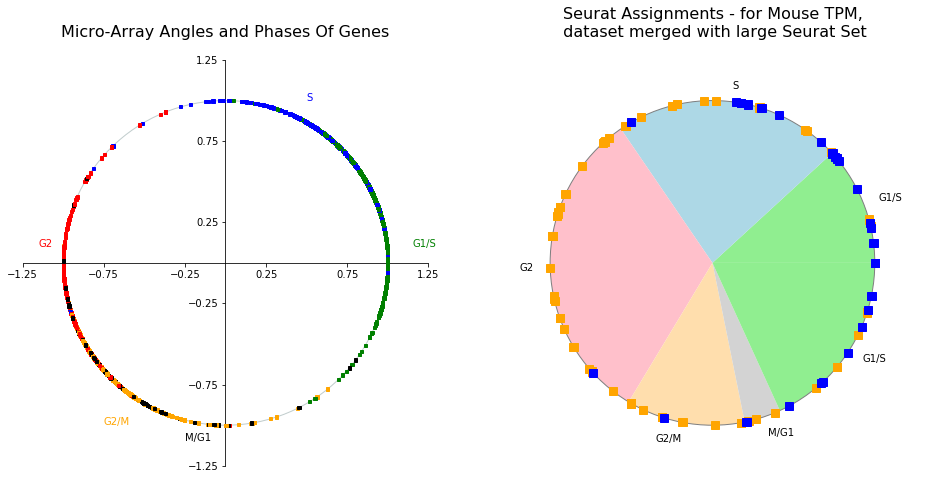

In [161]:
#print(whitfield_subset_micro_array_df)
#print(whitfield_subset_micro_array_df.sum(axis=0))
from pylab import *
figure(figsize=(16,8))


#### All Genes
ax=subplot(121, aspect='equal')

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.xaxis.set_ticks(np.arange(-1.25, 1.5, 0.5))
ax.yaxis.set_ticks(np.arange(-1.25, 1.5, 0.5))

#plot one circle (the biggest one on bottom-right)
# now make a circle with no fill, which is good for hi-lighting key results
circle = Circle((0, 0), 1.0, color='#C1CDCD', fill=False)
ax.add_artist(circle)
#circles(1, 0, 0.5, 'r', alpha=0.2, lw=5, edgecolor='b', transform=ax.transAxes)

#plot a set of circles (circles in diagonal)
#a=arange(11)
#out = circles(a, a, a*0.2, c=a, alpha=0.5, edgecolor='none')

# Create a Rectangle patches
for gene_name in gene_names_with_micro_array_data:
    use_color = 'gray'
    if (gene_name_to_time_course_expressions_dict[gene_name]["phase"] == 'G1/S'):
        use_color = 'green'
    elif (gene_name_to_time_course_expressions_dict[gene_name]["phase"] == 'S'):
        use_color = 'blue'
    elif (gene_name_to_time_course_expressions_dict[gene_name]["phase"] == 'G2'):
        use_color = 'red'
    elif (gene_name_to_time_course_expressions_dict[gene_name]["phase"] == 'G2/M'):
        use_color = 'orange'
    elif (gene_name_to_time_course_expressions_dict[gene_name]["phase"] == 'M/G1'):
        use_color = 'black'
    rect = Rectangle((gene_name_to_time_course_expressions_dict[gene_name]["cosine"]-0.01,gene_name_to_time_course_expressions_dict[gene_name]["sine"]-0.01),0.02,0.02,linewidth=1,edgecolor=use_color,facecolor=use_color,zorder=9)
    # Add the patch to the Axes
    ax.add_patch(rect)
    
text(1.15, 0.1, "G1/S", color='green')
text(0.5, 1, "S", color='blue')
text(-1.15, 0.1, "G2", color='red')
text(-0.75, -1, "G2/M", color='orange')
text(-0.25, -1.1, "M/G1", color='black')

title("Micro-Array Angles and Phases Of Genes\n", fontsize=16)

##########
# Phase segmentation on the circle
ax=subplot(122, aspect='equal')

labels = 'G1/S', 'S', 'G2', 'G2/M', 'M/G1', 'G1/S'
fracs = [13, 25, 35, 13, 4, 20]
colors = ["lightgreen", "lightblue", "pink", "navajowhite", "lightgrey", "lightgreen"]
plt.pie(fracs, labels=labels, colors = colors)

circle = Circle((0, 0), 1.0, color='grey', fill=False)
ax.add_artist(circle)

for i in range(0,len(angles_list)):
    use_color = 'gray'
    if (nesterova_plus_micro_array_phase_list[i] == 'G1'):
        use_color = 'darkgreen'
        order = 5
    elif (nesterova_plus_micro_array_phase_list[i] == 'S'):
        use_color = 'blue'
        order = 9
    elif (nesterova_plus_micro_array_phase_list[i] == 'G2M'):
        use_color = 'orange'
        order = 8
    rect = Rectangle((math.cos(angles_list[i])-0.025,math.sin(angles_list[i])-0.025),0.05,0.05,linewidth=1,edgecolor=use_color,facecolor=use_color,zorder=order)
    # Add the patch to the Axes
    ax.add_patch(rect)   

title("Seurat Assignments - for Mouse TPM,\n dataset merged with large Seurat Set\n", fontsize=16)



xlim(-1.25,1.25)
ylim(-1.25, 1.25)

show()